# Clonality, transcription factors, and chromatin accessibility.

This notebook contains explorations of ATAC peaks and gene expression, and their relation to clonality of T-cells.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

# Loading ATAC data

## Loading metadata and genes
We first load the metadata, which contains information about a whole lot of genes (including "pseudogenes", etc.).

In [2]:
metadata = pd.read_csv('P9855_All_Gene_Info_Metadata.csv', sep=',',
                       index_col=0, header=0, low_memory=False)
display(metadata.head())
genes = list(metadata.index)
print('{} ensemble gene ids contained in metadata.'.format(len(genes)))

,hgnc_symbol,chromosome_name,start_position,end_position,transcription_start_site,gene_biotype
ensembl_gene_id,,,,,,
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66119285,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66320895,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66339287,protein_coding
ENSG00000223116,NaN,13,23551994,23552136,23552136,miRNA
ENSG00000233440,HMGA1P6,13,23708313,23708703,23708313,pseudogene


196248 ensemble gene ids contained in metadata.


## Loading ATAC peak data

Next, we load the data for each ATAC peak interval.  For each interval, we have a score (related to peak height) for each 1000-ish cell bulk.  We also have a series of transcription factors that could bind at that interval, as a series of booleans.

In [3]:
interval_df = pd.read_csv('P9855_peakMappingNormCounts.csv', sep=',',
                       index_col=0, header=0, low_memory=False)
display(interval_df.head())
intervals = list(interval_df.index)
print('{} peak intervals found.'.format(len(intervals)))

,Chr,Start,End,Annotation,Distance.to.TSS,Nearest.PromoterID,clone1_R1,clone1_R2,clone10_R1,clone11_R1,...,MA0900.1_HOXA2,MA0901.1_HOXB13,MA0902.1_HOXB2,MA0903.1_HOXB3,MA0905.1_HOXC10,MA0906.1_HOXC12,MA0907.1_HOXC13,MA0908.1_HOXD11,MA0909.1_HOXD13,MA0914.1_ISL2
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_64780,7,77377824,77378383,intron (ENSG00000187257: intron 2 of 7),-19569,ENSG00000187257,0.919498,0.000000,2.214381,2.679470,...,False,False,False,False,False,False,False,False,False,False
Interval_46919,3,111845427,111847834,intron (ENSG00000174500: intron 2 of 4),5471,ENSG00000174500,5.516990,1.825506,0.000000,18.756289,...,False,False,False,False,False,False,False,False,False,False
Interval_74958,X,110487750,110488138,TTS (ENSG00000077274),-13655,ENSG00000234349,0.919498,1.217004,0.000000,5.358940,...,False,False,False,False,False,False,False,False,False,False
Interval_60507,6,90788786,90791144,intron (ENSG00000112182: intron 5 of 8),36859,ENSG00000218730,110.339792,111.964340,132.862857,150.050314,...,False,False,False,False,False,False,False,False,False,False
Interval_33109,19,45620515,45621413,intron (ENSG00000104866: intron 1 of 4),-10863,ENSG00000267346,4.597491,7.910524,15.500667,10.717880,...,False,False,False,False,False,False,False,False,False,False


75675 peak intervals found.


We focus on intervals at transcription start sites.  These can be identified by the word "promoter-TSS" in the annotation column of the dataframe above.

In [4]:
annotations = interval_df['Annotation']
intervals_TSS = [i for i in intervals if ('promoter-TSS' in annotations[i])]
TSS_df = interval_df.loc[intervals_TSS]
TSS_df.head()

,Chr,Start,End,Annotation,Distance.to.TSS,Nearest.PromoterID,clone1_R1,clone1_R2,clone10_R1,clone11_R1,...,MA0900.1_HOXA2,MA0901.1_HOXB13,MA0902.1_HOXB2,MA0903.1_HOXB3,MA0905.1_HOXC10,MA0906.1_HOXC12,MA0907.1_HOXC13,MA0908.1_HOXD11,MA0909.1_HOXD13,MA0914.1_ISL2
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_20581,14,65231284,65231710,promoter-TSS (ENSG00000070182),49076,ENSG00000126822,0.000000,1.825506,4.428762,0.000000,...,False,False,False,False,False,False,False,False,False,False
Interval_30225,18,33076958,33078342,promoter-TSS (ENSG00000153391),247,ENSG00000153391,107.581298,110.747336,117.362191,123.255615,...,False,False,False,False,False,False,False,False,False,False
Interval_74535,X,73640221,73641784,promoter-TSS (ENSG00000147100),11649,ENSG00000213695,6.436488,4.259513,11.071905,2.679470,...,False,False,False,False,False,False,False,False,False,False
Interval_50320,4,42657702,42659866,promoter-TSS (ENSG00000260519),326,ENSG00000124406,267.573996,219.060665,281.226381,353.690026,...,False,False,False,False,False,False,False,False,False,False
Interval_59743,6,49467259,49467649,promoter-TSS (ENSG00000203972),-217,ENSG00000203972,0.000000,0.608502,0.000000,2.679470,...,True,True,True,True,False,False,False,False,True,False


In [5]:
print('{} transcription start sites (TSSs) found'.format(len(TSS_df)))

13772 transcription start sites (TSSs) found


In [6]:
target_df = TSS_df['Annotation'].map(lambda ann : ann[-16:-1])
target_df.head()

: exonPeakID
Interval_20581    ENSG00000070182
Interval_30225    ENSG00000153391
Interval_74535    ENSG00000147100
Interval_50320    ENSG00000260519
Interval_59743    ENSG00000203972
Name: Annotation, dtype: object

In [7]:
gene_targets = list(target_df.unique())   
print('{} unique target genes associated to transcription start sites.'.format(len(gene_targets)))

12096 unique target genes associated to transcription start sites.


Now we turn our attention to the 1000-ish cell bulks.

In [8]:
bulks = list(TSS_df.columns[6:35])
print('{} bulks found: {}.'.format(len(bulks), ', '.join(bulks)))

29 bulks found: clone1_R1, clone1_R2, clone10_R1, clone11_R1, clone13_R1, clone14_R1, clone15_R1, clone15_R2, clone16_R1, clone17_R1, clone18_R1, clone19_R1, clone2_R1, clone20_R1, clone21_R1, clone22_R1, clone22_R2, clone23_R1, clone23_R2, clone24_R1, clone3_R1, clone4_R1, clone5a_R1, clone5b_R1, clone7_R1, clone8_R1, clone8_R2, clone9_R1, clone9_R2.


We pull out the peak heights for each bulk, and put it into a new dataframe.

In [9]:
peak_df = interval_df[bulks].transpose()
peak_df.head()

: exonPeakID,Interval_64780,Interval_46919,Interval_74958,Interval_60507,Interval_33109,Interval_14986,Interval_64951,Interval_3582,Interval_66707,Interval_22904,...,Interval_70506,Interval_24850,Interval_65581,Interval_39819,Interval_56295,Interval_1658,Interval_31119,Interval_45156,Interval_68449,Interval_8501
clone1_R1,0.919498,5.516990,0.919498,110.339792,4.597491,0.000000,0.000000,2.758495,6.436488,0.0,...,0.000000,0.000000,0.919498,11.953478,0.000000,52.411401,0.919498,0.919498,22.067958,0.0000
clone1_R2,0.000000,1.825506,1.217004,111.964340,7.910524,1.217004,0.000000,3.651011,3.651011,0.0,...,0.608502,0.608502,0.608502,9.736030,1.217004,63.284192,4.868015,2.434007,18.863557,0.0000
clone10_R1,2.214381,0.000000,0.000000,132.862857,15.500667,0.000000,0.000000,0.000000,4.428762,0.0,...,2.214381,0.000000,0.000000,2.214381,4.428762,53.145143,6.643143,0.000000,11.071905,0.0000
clone11_R1,2.679470,18.756289,5.358940,150.050314,10.717880,5.358940,2.679470,8.038410,5.358940,0.0,...,0.000000,0.000000,8.038410,10.717880,5.358940,64.307277,0.000000,0.000000,0.000000,0.0000
clone13_R1,0.000000,2.312933,1.156467,126.054875,9.251734,2.312933,4.625867,6.938800,5.782334,0.0,...,0.000000,0.000000,0.000000,13.877601,0.000000,69.388004,8.095267,1.156467,3.469400,3.4694


We perform a bit of string manipulation to give the clonality of each bulk.  (It's in the name already!)

In [110]:
clone_df = pd.DataFrame(columns = ['Clone'], index=bulks)
clone_df['Clone'] = [name[5:-3] for name in clone_df.index] # String manipulation.
clone_df.head()

,Clone
clone1_R1,1
clone1_R2,1
clone10_R1,10
clone11_R1,11
clone13_R1,13


In [111]:
clones = list(clone_df['Clone'].unique())
print('The {} bulks belong to the following {} clones:  {}'.format(len(bulks), len(clones), ', '.join(sorted(clones))))
clones_mult = [clone for clone in clones if clone_df['Clone'].value_counts()[clone] == 2]
print('The following clones contain two bulks:  {}'.format(', '.join(clones_mult)))

The 29 bulks belong to the following 23 clones:  1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 3, 4, 5a, 5b, 7, 8, 9
The following clones contain two bulks:  1, 15, 22, 23, 8, 9


Most of the clones only contain a single bulk.  For understanding the connection between clonality and ATAC peaks, we will want to consider clones with multiple bulks:  these are the six clones, numbered 1, 15, 22, 23, 8, 9.

In [112]:
clone_df_mult = clone_df[clone_df['Clone'].isin(clones_mult)]
bulks_mult = list(clone_df_mult.index)
clone_df_mult 

,Clone
clone1_R1,1
clone1_R2,1
clone15_R1,15
clone15_R2,15
clone22_R1,22
clone22_R2,22
clone23_R1,23
clone23_R2,23
clone8_R1,8
clone8_R2,8


## Transcription factors binding at each interval.

At each interval, there are many possible transcription factors that may bind.  We extract these here, using a dataframe of transcription factor binding sites (TFBS).

In [13]:
MAs = TSS_df.columns[35:]
TFBS_df = TSS_df[MAs]
TFBS_df.columns = [m[9:] for m in MAs] # A bit of string manipulation
TFBS_df.head()

,NFIL3,FOXF2,FOXD1,IRF2,MZF1,MZF1(var.2),MAX::MYC,PPARG,Pax6,PBX1,...,HOXA2,HOXB13,HOXB2,HOXB3,HOXC10,HOXC12,HOXC13,HOXD11,HOXD13,ISL2
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_20581,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_30225,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_74535,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_50320,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_59743,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,False,False,False,True,False


Some columns are "variants".  The computation below is to check something further below.

In [14]:
print(TFBS_df['MZF1'].sum(), TFBS_df['MZF1(var.2)'].sum(), (TFBS_df['MZF1']|TFBS_df['MZF1(var.2)']).sum())

5939 1711 6749


Each boolean True in the dataframe above indicates that the gene (column heading) above may bind at the interval (row heading).  The columns are transcription factors, and we place them into a list below.

In [15]:
TF_list = list(TFBS_df.columns)
print('{} transcription factors found with links to intervals.'.format(len(TF_list)))

386 transcription factors found with links to intervals.


We print the list of transcription factors below.  Some cleaning will be necessary to use this, since there are some variants (I think) labeled (var. 2), etc., and some like ARNT::HIF1A might indicate two related TFs?

In [16]:
print(', '.join(TF_list))

NFIL3, FOXF2, FOXD1, IRF2, MZF1, MZF1(var.2), MAX::MYC, PPARG, Pax6, PBX1, RORA, RORA(var.2), RREB1, RXRA::VDR, SOX9, SPIB, SRY, TAL1::TCF3, REL, RELA, NR1H2::RXRA, NFIC::TLX1, ZNF354C, CTCF, EWSR1-FLI1, REST, NFATC2, INSM1, HOXA5, RARA::RXRA, NR4A2, NFIC, PLAG1, CREB1, FOS::JUN, ARNT::HIF1A, SOX10, BATF::JUN, CDX2, DUX4, E2F4, E2F6, FOS, FOSL1, FOSL2, FOXH1, FOXP1, HNF4G, JUN, JUN(var.2), JUNB, JUND, JUND(var.2), MAFF, MAFK, MEF2C, MAF::NFE2, NFYB, NR2C2, NRF1, POU2F2, PRDM1, SMAD2::SMAD3::SMAD4, SP2, STAT1::STAT2, TCF7L2, USF2, ZBTB33, ZNF263, CEBPA, EGR1, ELK4, ESR2, FOXA1, GATA2, GATA3, IRF1, NFYA, PAX5, SP1, STAT1, STAT3, GATA1::TAL1, USF1, YY1, ZEB1, FOXP2, SREBF1, SREBF2, THAP1, KLF5, DMRT3, EMX1, FOXG1, LBX1, NFATC3, POU6F1, SHOX, ALX3, BARHL2, BHLHE41, CENPB, CREB3, DBP, EBF1, EHF, ELF3, ELF4, ELF5, EN1, EN2, ESX1, ETV6, FLI1, FOXI1, FOXL1, FOXO3, GCM1, GRHL1, GSC, HEY2, HINFP, HLF, HNF1A, HNF1B, HOXA13, HOXC11, HSF1, IRF8, IRF9, ISX, JDP2, JDP2(var.2), KLF13, LHX6, MAFG, MEF2

We "consolidate" variants like MZF1 and MZF1(var.2), by applying boolean OR to the two columns, and just calling the resulting column MZF1.

In [17]:
pd.options.mode.chained_assignment = None # Suppress an annoying warning.

for TF in TF_list:
    for variant in ['(var.2)', '(var.3)']:
        TFvar = TF+variant
        if TFvar in TF_list:
            TFBS_df[TF] = (TFBS_df[TF] | TFBS_df[TFvar])
            TFBS_df.drop(TFvar, axis=1, inplace=True)

In [18]:
TFBS_df.head()

,NFIL3,FOXF2,FOXD1,IRF2,MZF1,MAX::MYC,PPARG,Pax6,PBX1,RORA,...,HOXA2,HOXB13,HOXB2,HOXB3,HOXC10,HOXC12,HOXC13,HOXD11,HOXD13,ISL2
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_20581,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_30225,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_74535,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_50320,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_59743,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,False,False,False,True,False


In [19]:
print(TFBS_df['MZF1'].sum()) # Compare to the computation earlier.

6749


Now we deal with transcription factors like MAX::MYC that seem to denote two closely related TFs.  We take each such instance and turn it into two columns.  E.g., the column MAX::MYC becomes two columns, one labeled MAX and the other MYC, both with the same True/False values.

In [20]:
for TF in TF_list:
    if '::' in TF:
        for gene in TF.split('::'):
            TFBS_df[gene] = TFBS_df[TF]
        TFBS_df.drop(TF, axis=1, inplace=True)

In [21]:
TFBS_df.head()

,NFIL3,FOXF2,FOXD1,IRF2,MZF1,PPARG,Pax6,PBX1,RORA,RREB1,...,NR1H2,TLX1,ARNT,HIF1A,BATF,MAF,SMAD2,SMAD4,STAT2,GATA1
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_20581,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_30225,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_74535,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
Interval_50320,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_59743,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


With all this string manipulation out of the way, we recreate our cleaned list of transcription factors below.

In [22]:
TF_list = list(TFBS_df.columns)
print('We are studying binding sites for {} transcription factors: {}'.format(len(TF_list), ', '.join(TF_list)))

We are studying binding sites for 374 transcription factors: NFIL3, FOXF2, FOXD1, IRF2, MZF1, PPARG, Pax6, PBX1, RORA, RREB1, SOX9, SPIB, SRY, REL, RELA, ZNF354C, CTCF, EWSR1-FLI1, REST, NFATC2, INSM1, HOXA5, NR4A2, NFIC, PLAG1, CREB1, SOX10, CDX2, DUX4, E2F4, E2F6, FOS, FOSL1, FOSL2, FOXH1, FOXP1, HNF4G, JUN, JUNB, JUND, MAFF, MAFK, MEF2C, NFYB, NR2C2, NRF1, POU2F2, PRDM1, SP2, TCF7L2, USF2, ZBTB33, ZNF263, CEBPA, EGR1, ELK4, ESR2, FOXA1, GATA2, GATA3, IRF1, NFYA, PAX5, SP1, STAT1, STAT3, USF1, YY1, ZEB1, FOXP2, SREBF1, SREBF2, THAP1, KLF5, DMRT3, EMX1, FOXG1, LBX1, NFATC3, POU6F1, SHOX, ALX3, BARHL2, BHLHE41, CENPB, CREB3, DBP, EBF1, EHF, ELF3, ELF4, ELF5, EN1, EN2, ESX1, ETV6, FLI1, FOXI1, FOXL1, FOXO3, GCM1, GRHL1, GSC, HEY2, HINFP, HLF, HNF1A, HNF1B, HOXA13, HOXC11, HSF1, IRF8, IRF9, ISX, JDP2, KLF13, LHX6, MAFG, MEF2B, MEOX1, MIXL1, MLX, MLXIPL, MSC, MSX1, MYF6, NEUROD2, NEUROG2, NFIA, NFIX, NHLH1, NKX2-3, NKX2-8, NKX6-1, NKX6-2, OLIG2, ONECUT1, PAX4, PAX7, POU4F2, RUNX3, SP4, SP

Now we summarize the relationship between peak intervals and TFs.

In [23]:
TFBS_df.sum(axis=1).describe()

count    13772.000000
mean        24.061066
std          9.121214
min          0.000000
25%         18.000000
50%         23.000000
75%         29.000000
max         79.000000
dtype: float64

We are studying roughly 14000 intervals where peaks appear in ATAC data at TSSs.  An interval is associated with 24 (+/- 9) transcription factors (average +/- std).

In [24]:
TFBS_df.sum(axis=0).describe()

count     374.000000
mean      886.013369
std      1298.766816
min        78.000000
25%       245.250000
50%       478.000000
75%       893.500000
max      8881.000000
dtype: float64

Each TF binds to 886 transcription start site intervals, on average.  The distribution is pretty wild, with a minimum of 78 and maximum of 8881 intervals!  (Histogram below)

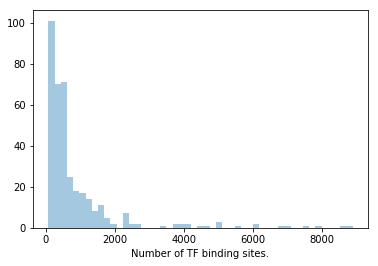

In [26]:
sns.distplot(TFBS_df.sum(axis=0), kde=False, axlabel='Number of TF binding sites.')

# tSNE clustering based on ATAC peaks

Note:  This analysis was first done by Joseph... I'm just trying it again to play with the data and check that everything works.

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

We perform tSNE clustering on the ATAC peak data, using the 10 bulks with 2 bulks per clone.  We first reduce dimensionality by using the top ten principal components.  Then we carry out tSNE clustering with "perplexity" parameter 2, corresponding to our desire to create clusters of two bulks each.

First, we cluster the bulks using all 75000ish peaks.

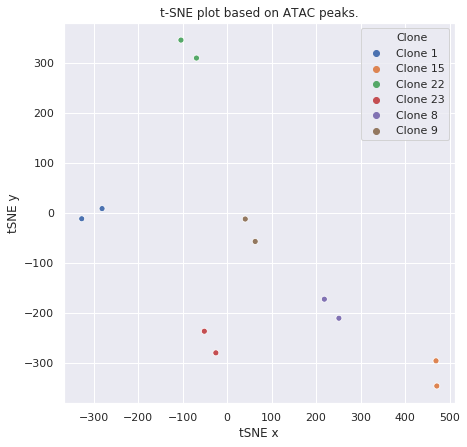

In [28]:
X = peak_df.loc[bulks_mult] # We'll cluster the bulks based on ATAC peaks.  
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = TSNE(n_components=2, perplexity=2).fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['tSNE x', 'tSNE y'], index=bulks_mult) # Just for graphing.
cl_df['Clone'] = 'Clone ' + clone_df_mult

sns.set(rc={'figure.figsize':(7,7)})
ax = sns.scatterplot(x='tSNE x', y='tSNE y', hue='Clone', data = cl_df)
ax.set_title("t-SNE plot based on ATAC peaks.")
plt.show()

This is very nice... the tSNE plot produces clusters (pairs) which coincide with the pairs of the same clonotype.  Now we try again, but using only the peak intervals at transcription start sites.  

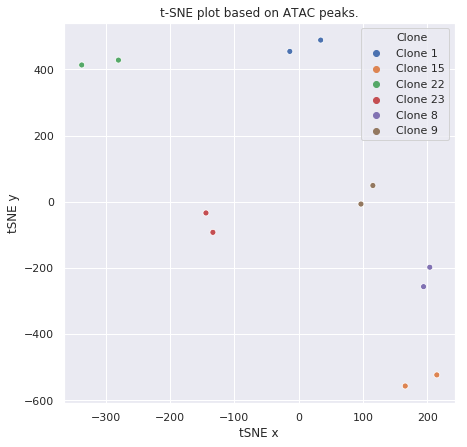

In [29]:
X = peak_df[intervals_TSS].loc[bulks_mult] # We'll cluster the bulks based on ATAC peaks.  
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = TSNE(n_components=2, perplexity=2).fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['tSNE x', 'tSNE y'], index=bulks_mult) # Just for graphing.
cl_df['Clone'] = 'Clone ' + clone_df_mult

sns.set(rc={'figure.figsize':(7,7)})
ax = sns.scatterplot(x='tSNE x', y='tSNE y', hue='Clone', data = cl_df)
ax.set_title("t-SNE plot based on ATAC peaks.")
plt.show()

The clustering still works out very nicely, using just the transcription start sites.  There's plenty of clonal information in the ATAC peaks.

# Clonal behavior of ATAC peaks.

Here we carry out an analysis of ATAC peaks which carry clonal information, loosely inspired by [DiffTF](https://www.biorxiv.org/content/10.1101/368498v2).  The clustering exhibits that ATAC peaks carry enough information to recover clonality.  But here we approach the question:  how much clonal information do ATAC peaks carry, and which peaks carry the most? We associate this with prior activity of transcription factors.

In [44]:
import statsmodels.api as sm

from bisect import bisect # See bisect.bisect.
from itertools import compress, permutations # I don't recall why this is here.

# Import from scikit, for machine learning.

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_regression, mutual_info_classif
from sklearn.metrics import mutual_info_score

We let `X` be the dataframe containing the peak heights for all TSS intervals and the 12 bulks from 6 clones.  But now we log_2-normalize the values.  This way, a difference of 1 corresponds to a 2-fold change.

In [31]:
X = peak_df[intervals_TSS].loc[bulks_mult].apply(np.log1p)
X = X / np.log(2) # Want log base 2.
display(X)

: exonPeakID,Interval_20581,Interval_30225,Interval_74535,Interval_50320,Interval_59743,Interval_11609,Interval_56584,Interval_31997,Interval_32438,Interval_49980,...,Interval_7718,Interval_26482,Interval_38036,Interval_33534,Interval_40626,Interval_25317,Interval_326,Interval_39671,Interval_29395,Interval_1658
clone1_R1,0.000000,6.762632,2.894621,8.069176,0.000000,0.000000,3.589042,5.925225,7.660852,8.013795,...,6.661426,4.837184,3.886791,5.308118,5.763701,5.130166,2.704206,1.910155,5.925225,5.739076
clone1_R2,1.498509,6.804097,2.394929,7.781757,0.685718,0.000000,4.267165,5.297764,7.686957,7.918665,...,6.508718,5.425816,3.906462,5.405248,5.847763,5.297764,3.340210,1.779893,5.964830,6.006392
clone15_R1,3.369457,6.829561,1.657281,7.800151,0.780790,1.953186,4.494554,5.638910,8.314641,7.975029,...,7.072120,5.869026,3.369457,4.893502,3.369457,5.638910,2.591321,1.284599,6.113051,6.321710
clone15_R2,2.288682,6.887039,1.353006,7.767152,0.829622,2.501647,4.177824,5.771572,8.299192,7.995205,...,6.877534,6.084082,3.255412,5.168917,4.048269,5.831872,3.978851,0.829622,5.998980,6.368210
clone22_R1,2.057316,6.660118,2.057316,7.895778,1.038463,1.636022,4.071296,5.829444,7.265244,7.952129,...,6.614290,5.689126,2.382986,5.855941,5.466482,4.931355,2.382986,1.038463,5.907518,6.140911
clone22_R2,0.924122,6.845318,2.456188,7.899933,2.198531,1.482879,4.605006,6.055709,7.211352,7.850297,...,6.573505,5.912577,3.032143,5.519683,5.547635,5.170071,3.557086,2.456188,6.075045,6.112955
clone23_R1,1.863581,6.976333,2.175939,7.908562,0.000000,0.910502,4.679851,5.840482,7.740707,7.934733,...,6.925036,5.947181,3.416393,5.462879,5.884113,5.177438,4.347197,0.000000,6.489441,6.209747
clone23_R2,2.336711,7.018311,2.013863,7.759836,0.000000,1.597292,4.541219,5.925040,7.436200,8.084475,...,6.799648,5.773003,4.104838,5.477469,5.746029,5.147214,3.476218,1.009257,6.167943,6.375783
clone8_R1,1.757808,7.070207,2.526990,7.850796,0.000000,0.000000,3.877310,6.428792,8.045450,7.968653,...,6.871778,5.832212,3.550689,5.862058,6.016011,5.126858,3.622197,1.131537,6.016011,6.367686
clone8_R2,1.996891,6.943085,3.133829,7.800648,0.000000,0.676518,3.996113,5.968612,7.944237,7.808370,...,6.559665,6.035932,3.031983,5.777288,5.808425,5.296082,3.696612,1.482762,6.074866,6.363973


We place the clonality information into a series called `y`.  

In [113]:
y = clone_df_mult['Clone']
display(y)

clone1_R1      1
clone1_R2      1
clone15_R1    15
clone15_R2    15
clone22_R1    22
clone22_R2    22
clone23_R1    23
clone23_R2    23
clone8_R1      8
clone8_R2      8
clone9_R1      9
clone9_R2      9
Name: Clone, dtype: object

## Creation of mutual information (MI) dataframe.

This step creates a dataframe, describing the clonal information content of each peak and the results of a permutation test.  The permutation test can take an hour or two to run, so skip this step and load the pickle if you have it!

To run permutation tests, we consider a series of "genuine" ways of mixing up clone labels.  We begin with a function to produce all [derangements](https://en.wikipedia.org/wiki/Derangement) of a list.

In [33]:
def derangements(L):
    D = []
    for P in permutations(L):
        M = [L[i] == P[i] for i in range(len(L))]
        if sum(M) == 0:
            D += [P]
    return D

In [34]:
len(derangements([1,2,3,4,5,6])) # Should be 265.

265

Recall that there are 12 bulks, which belong to 6 clones.  I.e., the bulks come in clonal pairs in our data.  To permute the data, we permute the clone-label for one bulk in each pair, using the derangements.  The effect is to produce a new pairing-off, in which no two clonal bulks are paired.  In other words, we purposely destroy some clonal information in our new clone-labellings.  

In [114]:
y_shuff_df = pd.DataFrame(index = y.index)
D = derangements(clones_mult)
for i in range(len(D)):
    col = [0]*len(y)
    col[0::2] = clones_mult
    col[1::2] = D[i]
    y_shuff_df['Shuffle_'+str(i)] = col
display(y_shuff_df)

,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,Shuffle_9,...,Shuffle_255,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264
clone1_R1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
clone1_R2,15,15,15,15,15,15,15,15,15,15,...,9,9,9,9,9,9,9,9,9,9
clone15_R1,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
clone15_R2,1,1,1,1,1,1,1,1,1,22,...,8,8,8,8,8,8,8,8,8,8
clone22_R1,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
clone22_R2,23,23,23,8,8,8,9,9,9,1,...,15,15,15,15,23,23,23,23,23,23
clone23_R1,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
clone23_R2,22,8,9,22,9,9,22,8,8,8,...,1,1,22,22,1,1,15,15,22,22
clone8_R1,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
clone8_R2,9,9,22,9,22,23,23,22,23,9,...,22,23,1,23,15,22,1,22,1,15


Each column of the `y_shuff_df` dataframe gives a shuffling of the clone-labels, in such a way that no two bulks of the same clone end up with the same clone-label after shuffling.  These provide a series of "null-hypotheses" for what follows.

Now we compute the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between the peak heights at each interval and clonality.  In this way, each interval is assigned a mutual information score -- the higher the score, the more clonal information is contained in the peak heights at that interval.  We use the scikit function [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) to compute mutual information, since it deals well with a discrete target variable (clonality) and continuous feature (ATAC peak height).

In [128]:
import time

The following takes 40 seconds to compute... be patient.

In [129]:
start_time = time.time()
mi = pd.Series(mutual_info_classif(X, y, n_neighbors=3), index=X.columns) # Takes a little while.
print('Computation took {:2.3f} seconds.'.format(time.time() - start_time))
mi.sort_values(ascending=False).head() # Print 5 most informative peaks.

Computation took 37.717 seconds.


: exonPeakID
Interval_71274    1.762933
Interval_42050    1.686544
Interval_34726    1.686544
Interval_40365    1.644877
Interval_2235     1.630988
dtype: float64

Note that the values above are not "robust" -- they will change every time the mutual information is.  But they will not vary too broadly.  We show this by running the MI computation 100 times, on the first 100 ATAC peak intervals.

In [132]:
mi_robust = pd.DataFrame(index=X.columns[:100], columns = range(100))
for j in range(100):
    mi_robust[j] = pd.Series(mutual_info_classif(X[X.columns[:100]], y, n_neighbors=3), index=X.columns[:100])
mi_robust.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_20581,0.017265,0.058932,0.000000,0.000000,0.000000,0.038098,0.000000,0.000000,0.052450,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045043,0.000000,0.000000,0.045043
Interval_30225,0.140049,0.186346,0.140049,0.177086,0.045142,0.204864,0.186346,0.184031,0.140049,0.177086,...,0.267364,0.084494,0.211809,0.204864,0.246531,0.114586,0.140049,0.200234,0.267364,0.225697
Interval_74535,0.285552,0.224540,0.400135,0.118885,0.175598,0.362635,0.314123,0.262040,0.150135,0.223052,...,0.225003,0.334957,0.112635,0.359957,0.359957,0.315182,0.276293,0.193753,0.225003,0.287503
Interval_50320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040545,0.000000,0.000000
Interval_59743,0.867364,0.379134,0.417463,0.621994,0.294511,0.651392,0.505559,0.290281,0.366670,0.419811,...,0.398614,0.325165,0.274140,0.453538,0.466074,0.173776,0.368717,0.086872,0.554864,0.699209


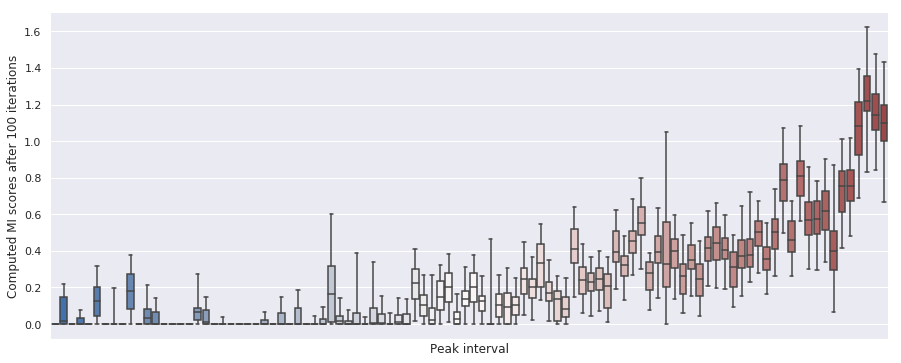

In [133]:
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=mi_robust.sort_values(0).transpose(),
            whis="range", palette="vlag")
ax.xaxis.grid(False)
ax.xaxis.set_ticks([])
ax.set(ylabel="Computed MI scores after 100 iterations")
ax.set(xlabel="Peak interval")
sns.despine(trim=True, left=True)

The MI scores certainly exhibit some uncertainty.  If an ATAC interval has an MI score of 1.0 (after one computation), it might be interpreted as a score of 1.0 +/- 0.1.  The "box" (between 25% and 75% quartiles) typically has a height less than 0.2.

Now we plot a histogram of MI-scores for the 14000 or so TSS peaks, excluding those whose score is zero.

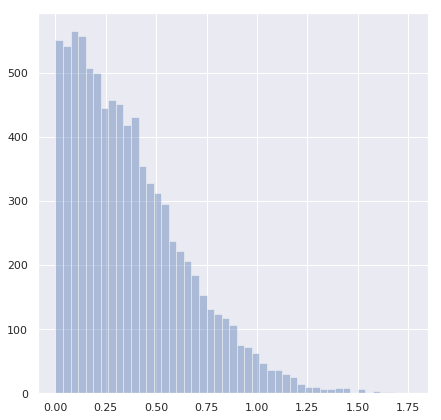

In [134]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Getting sick of FutureWarnings.

sns.distplot(mi[mi > 0.0], kde=False)

Let's look at intervals with high MI scores.

In [138]:
mi.sort_values(ascending=False)[:10]

: exonPeakID
Interval_71274    1.762933
Interval_42050    1.686544
Interval_34726    1.686544
Interval_40365    1.644877
Interval_2235     1.630988
Interval_49970    1.603211
Interval_34819    1.603211
Interval_49348    1.603211
Interval_60987    1.575433
Interval_44230    1.561544
dtype: float64

In [139]:
X.Interval_71274

clone1_R1     7.339068
clone1_R2     7.331239
clone15_R1    2.753727
clone15_R2    1.353006
clone22_R1    7.424201
clone22_R2    7.690237
clone23_R1    7.208574
clone23_R2    7.157876
clone8_R1     6.080903
clone8_R2     5.912399
clone9_R1     6.392153
clone9_R2     6.439093
Name: Interval_71274, dtype: float64

This high-MI-scorer certainly conveys clonal information in the peak heights.  Recall that a 1.0-difference in log-normalized height means a 2-fold difference.

Now we carry out the permutation test.  This will compute the same mutual informations, but for all 265 derangements of the clone labels.  You can expect this to take 265 * 40 seconds, or a few hours.  If you have the pickle, just load it!

In [ ]:
mi_df = pd.DataFrame(index=intervals_TSS)
mi_df['Original'] = mi
for j in range(265):
    col_name = 'Shuffle_'+str(j)
    mi_df[col_name] = pd.Series(mutual_info_classif(X, y_shuff_df[col_name], n_neighbors=3), 
                                index=X.columns) # Takes a little while.
    if j%10 == 0:
        print('{} jobs done.'.format(j))
    
    #X.apply(lambda col : calc_MI(col,y_shuff_df[col_name],6))

In [143]:
mi_df['Null'] = mi_df.drop(columns=['Original']).mean(axis=1)
mi_df.to_pickle('MI_P9855.pkl')
mi_df.head()

,Original,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264,Null
Interval_20581,0.000000,0.000000,0.000000,0.0,0.000000,0.090578,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.378178,0.000000,0.0,0.000000,0.000000,0.121824
Interval_30225,0.265049,0.000000,0.327417,0.0,0.000000,0.000000,0.303045,0.136736,0.063194,0.903211,...,0.636709,0.0,0.454203,0.000000,0.000000,0.091008,0.0,0.000000,0.000000,0.085013
Interval_74535,0.224540,0.444411,0.000000,0.0,0.418654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.102020,0.000000,0.000000,0.000000,0.0,0.166703,0.131776,0.101564
Interval_50320,0.000000,0.000000,0.000000,0.0,0.060086,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.231151,0.000000,0.000000,0.0,0.000000,0.076389,0.008322
Interval_59743,0.299140,0.022854,0.027252,0.0,0.000000,0.000000,0.070406,0.000000,0.000000,0.102814,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.060248


## Analysis of clonal information of ATAC peaks.

Start here if you have the pickle!

In [144]:
mi_df = pd.read_pickle('MI_P9855.pkl')
mi_df.head()

,Original,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264,Null
Interval_20581,0.000000,0.000000,0.000000,0.0,0.000000,0.090578,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.378178,0.000000,0.0,0.000000,0.000000,0.121824
Interval_30225,0.265049,0.000000,0.327417,0.0,0.000000,0.000000,0.303045,0.136736,0.063194,0.903211,...,0.636709,0.0,0.454203,0.000000,0.000000,0.091008,0.0,0.000000,0.000000,0.085013
Interval_74535,0.224540,0.444411,0.000000,0.0,0.418654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.102020,0.000000,0.000000,0.000000,0.0,0.166703,0.131776,0.101564
Interval_50320,0.000000,0.000000,0.000000,0.0,0.060086,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.231151,0.000000,0.000000,0.0,0.000000,0.076389,0.008322
Interval_59743,0.299140,0.022854,0.027252,0.0,0.000000,0.000000,0.070406,0.000000,0.000000,0.102814,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.060248


To compare the "real" MI scores with the shuffles, we total up the columns.  The numbers may be thought of as the "total information" provided by the ATAC peaks about clonality. 

In [145]:
mi_df.sum(axis=0)

Original       3240.720259
Shuffle_0       846.169496
Shuffle_1       739.526963
Shuffle_2       727.022724
Shuffle_3       762.061099
Shuffle_4       725.773316
Shuffle_5       710.132116
Shuffle_6       778.265993
Shuffle_7       714.586803
Shuffle_8       781.752790
Shuffle_9       757.064761
Shuffle_10      757.564021
Shuffle_11      789.704924
Shuffle_12      695.397727
Shuffle_13      716.273614
Shuffle_14      696.996898
Shuffle_15      684.577471
Shuffle_16      644.783902
Shuffle_17      718.971702
Shuffle_18      713.276557
Shuffle_19      706.770698
Shuffle_20      898.574943
Shuffle_21      827.511646
Shuffle_22      779.894150
Shuffle_23      740.116291
Shuffle_24      729.355444
Shuffle_25      718.308914
Shuffle_26      687.658592
Shuffle_27      736.796994
Shuffle_28      790.397742
                  ...     
Shuffle_236     675.465816
Shuffle_237     787.205519
Shuffle_238     889.535792
Shuffle_239     855.567256
Shuffle_240     746.940455
Shuffle_241     708.386893
S

Note that the "Original" column contains the most information... that's good!

We normalize this "information matrix" by subtracting off the null column from all the others.  We consider the null column as the *intrinsic* information content of each peak interval.  For example, an interval in which peak height has high variance will naturally convey more information about clonality than an interval with no peak height variance.  The null column is an empirical estimation of this intrinsic information content.

In [146]:
mi_eff = mi_df.copy().drop('Null', axis=1)
mi_eff = mi_eff.apply(lambda col : col - mi_df['Null'])
mi_eff.head()

,Original,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_255,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264
Interval_20581,-0.121824,-0.121824,-0.121824,-0.121824,-0.121824,-0.031246,-0.121824,-0.121824,-0.121824,-0.121824,...,-0.121824,-0.121824,-0.121824,-0.121824,-0.121824,0.256353,-0.121824,-0.121824,-0.121824,-0.121824
Interval_30225,0.180036,-0.085013,0.242404,-0.085013,-0.085013,-0.085013,0.218032,0.051723,-0.021819,0.818197,...,-0.042619,0.551696,-0.085013,0.369189,-0.085013,-0.085013,0.005995,-0.085013,-0.085013,-0.085013
Interval_74535,0.122976,0.342847,-0.101564,-0.101564,0.317090,-0.101564,-0.101564,-0.101564,-0.101564,-0.101564,...,-0.101564,-0.101564,-0.101564,0.000456,-0.101564,-0.101564,-0.101564,-0.101564,0.065139,0.030212
Interval_50320,-0.008322,-0.008322,-0.008322,-0.008322,0.051764,-0.008322,-0.008322,-0.008322,-0.008322,-0.008322,...,-0.008322,-0.008322,-0.008322,-0.008322,0.222829,-0.008322,-0.008322,-0.008322,-0.008322,0.068067
Interval_59743,0.238892,-0.037395,-0.032996,-0.060248,-0.060248,-0.060248,0.010158,-0.060248,-0.060248,0.042566,...,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248,-0.060248


In [148]:
mi_eff.describe()

,Original,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_255,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264
count,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,...,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000,13772.000000
mean,0.179306,0.005435,-0.002309,-0.003217,-0.000673,-0.003307,-0.004443,0.000504,-0.004120,0.000757,...,-0.003542,-0.000169,-0.000785,0.000951,0.009059,-0.002226,-0.000177,-0.002366,0.002247,0.011217
std,0.300313,0.135679,0.124150,0.123418,0.128486,0.128712,0.122687,0.127173,0.122669,0.133777,...,0.123215,0.126698,0.124993,0.129185,0.137661,0.123868,0.125862,0.123485,0.130734,0.143517
min,-0.218713,-0.216542,-0.218713,-0.218713,-0.216542,-0.216542,-0.218713,-0.216542,-0.216542,-0.216542,...,-0.212646,-0.218713,-0.202773,-0.206125,-0.218713,-0.218713,-0.218713,-0.218713,-0.218713,-0.216542
25%,-0.051882,-0.061665,-0.062909,-0.063330,-0.062800,-0.064199,-0.064010,-0.062036,-0.063931,-0.064078,...,-0.062910,-0.062354,-0.062117,-0.062377,-0.060911,-0.062623,-0.062098,-0.062674,-0.061762,-0.061012
50%,0.071889,-0.034008,-0.035262,-0.035954,-0.035397,-0.036502,-0.036245,-0.034663,-0.035954,-0.035621,...,-0.035457,-0.034334,-0.035037,-0.035043,-0.032300,-0.035043,-0.034478,-0.035191,-0.034251,-0.032698
75%,0.349003,-0.003356,-0.006453,-0.007994,-0.006620,-0.008573,-0.008556,-0.005379,-0.008267,-0.006536,...,-0.008029,-0.005298,-0.006285,-0.005825,-0.001061,-0.006740,-0.005918,-0.006843,-0.005019,-0.000952
max,1.840478,1.170293,1.032429,1.209918,1.297695,1.450990,1.099897,1.194365,0.941499,1.393828,...,1.203615,1.191439,1.138317,1.266145,1.110243,1.080841,1.004982,1.205537,1.079581,1.089514


The column-sums may be interpreted as the total clonal information contained in the ATAC data.  We may compare this total information content with permuted clone labels.

In [147]:
mi_eff.sum(axis=0).head()

Original     2469.396992
Shuffle_0      74.846228
Shuffle_1     -31.796304
Shuffle_2     -44.300543
Shuffle_3      -9.262168
dtype: float64

We see that the ATAC data contains more information about the *actual* clone labels as compared to the permuted clone labels.

The mutual information (MI) dataframe describes how much information *each* ATAC peak contains about the clone labels.  But MI can be a difficult statistic to interpret on its own.  The permutation test allows us to determine the significance of each ATAC peak, to say how many ATAC peaks *really* contain clonal information with some estimate of certainty.

The (normalized) mutual information scores (for each ATAC peak and each shuffling) are numbers between about -0.5 and 2.0.  We bin these for each shuffling, to compare distributions.

In [149]:
bins = np.linspace(-0.5, 2.0, num=31)
bin_centers = [(bins[i+1] + bins[i])*0.5 for i in range(len(bins) - 1)]
mi_hist = pd.DataFrame(index = bin_centers)
for shuff in mi_eff.columns:
    mi_hist[shuff] = np.histogram(mi_eff[shuff], bins)[0]
mi_hist

,Original,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_255,Shuffle_256,Shuffle_257,Shuffle_258,Shuffle_259,Shuffle_260,Shuffle_261,Shuffle_262,Shuffle_263,Shuffle_264
-0.458333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0.375000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0.291667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0.208333,61,32,31,36,30,32,36,28,27,24,...,34,29,27,30,36,28,28,29,26,37
-0.125000,1816,1606,1724,1730,1679,1793,1748,1654,1746,1772,...,1695,1675,1658,1680,1642,1703,1706,1731,1621,1615
-0.041667,3977,9007,9129,9231,9200,9228,9261,9120,9263,9091,...,9272,9088,9174,9122,8766,9178,9115,9165,9132,8768
0.041667,1192,1011,1033,904,938,891,895,967,921,895,...,928,1027,957,941,1023,990,943,942,988,1053
0.125000,1147,686,634,646,636,630,664,707,615,686,...,641,688,691,684,771,644,671,662,676,695
0.208333,1064,479,420,453,486,420,404,456,438,414,...,463,479,463,478,534,452,476,470,454,527
0.291667,917,377,318,317,303,276,299,328,307,330,...,271,279,336,304,366,311,343,310,352,409


At the high end, we see that there are far more ATAC peaks which provide information about the real clone labels, as compared to the shuffled labels.  We quantify this in a few steps here.  First we plot the information content among the ATAC peaks -- comparing the real information content to a null hypothesis.

In [150]:
mi_hist['Null'] = mi_hist.drop(['Original'], axis=1).mean(axis=1)

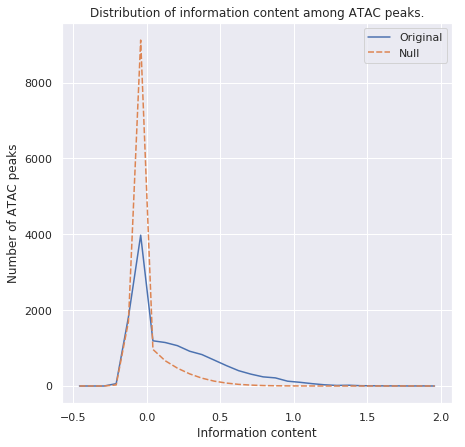

In [151]:
sns.lineplot(data = mi_hist[ ['Original', 'Null']])
plt.xlabel('Information content')
plt.ylabel('Number of ATAC peaks')
plt.title('Distribution of information content among ATAC peaks.')
plt.show()

We see that when the clone labels are shuffled, most ATAC peaks carry almost no information about the clone labels (the tall peak above 0.0).  But for the original clone labels, we see a "fat tail" of ATAC peaks which carry information about clonality (the blue line above the orange line).  Comparing these distributions allows us to esimate the number of ATAC peaks which convey clonal information.

In [152]:
real_proportion = (mi_hist['Original'] - mi_hist['Null']) / (mi_hist['Original'])
real_proportion

-0.458333         NaN
-0.375000         NaN
-0.291667         NaN
-0.208333    0.534303
-0.125000    0.067411
-0.041667   -1.293620
 0.041667    0.189927
 0.125000    0.418743
 0.208333    0.557522
 0.291667    0.651052
 0.375000    0.750288
 0.458333    0.811928
 0.541667    0.856106
 0.625000    0.892864
 0.708333    0.922768
 0.791667    0.948798
 0.875000    0.969494
 0.958333    0.976200
 1.041667    0.983596
 1.125000    0.989653
 1.208333    0.990212
 1.291667    0.990189
 1.375000    0.998113
 1.458333    0.996698
 1.541667    0.999245
 1.625000    1.000000
 1.708333    1.000000
 1.791667         NaN
 1.875000    1.000000
 1.958333         NaN
dtype: float64

This suggests that among ATAC peaks with MI score above 0.8, over 95% are "genuine" conveyers of clonal information (only 5% or less expected by chance).  And ATAC peaks with MI scores above 1.2 are significant at the p < 0.01 level.

In [153]:
peaks_eff = mi_eff['Original']
sig_peaks = peaks_eff[ peaks_eff >= 0.8]
print('{} clonal peak intervals found with information scores > 0.8 (one-tailed p < 0.05). \n'
      'The most significant ones are below.'.format(len(sig_peaks)))
display(sig_peaks.sort_values(ascending=False).head())
print('And now the least significant ones.')
display(sig_peaks.sort_values().head())

661 clonal peak intervals found with information scores > 0.8 (one-tailed p < 0.05). 
The most significant ones are below.


Interval_42050    1.840478
Interval_12959    1.840420
Interval_34902    1.714832
Interval_34726    1.682122
Interval_71956    1.679349
Name: Original, dtype: float64

And now the least significant ones.


Interval_32337    0.800339
Interval_33528    0.800946
Interval_28697    0.801099
Interval_28347    0.801607
Interval_13831    0.801743
Name: Original, dtype: float64

To see the difference between the highest information content and the lowest (but still significant) information content, here are two examples.  Remember, this is log-scaled, so a difference of about 1.0 corresponds to a 2-fold difference in the peak height.

In [154]:
display(X['Interval_12959'])

display(X['Interval_25295'])

clone1_R1     6.725507
clone1_R2     6.574674
clone15_R1    3.557174
clone15_R2    3.368297
clone22_R1    8.114564
clone22_R2    8.044264
clone23_R1    5.818162
clone23_R2    5.948891
clone8_R1     5.512843
clone8_R2     5.381384
clone9_R1     4.385313
clone9_R2     4.162388
Name: Interval_12959, dtype: float64

clone1_R1     1.910155
clone1_R2     0.000000
clone15_R1    0.780790
clone15_R2    0.829622
clone22_R1    1.038463
clone22_R2    0.924122
clone23_R1    2.432558
clone23_R2    2.013863
clone8_R1     0.000000
clone8_R2     1.135243
clone9_R1     1.296294
clone9_R2     1.405658
Name: Interval_25295, dtype: float64

## Analysis of transcription factors via binding sites

Having found ATAC peaks with clonal information, we consider the TFs that may bind at those intervals.

In [155]:
sig_TSSs = list(sig_peaks.index)
print('We are studying {} ATAC peaks with clonal information.'.format(len(sig_TSSs)))

We are studying 661 ATAC peaks with clonal information.


The TFs that bind at those intervals are given by the True entries in the dataframe below.

In [156]:
sigpeak_TFs = TFBS_df.loc[sig_TSSs]
sigpeak_TFs.head()

,NFIL3,FOXF2,FOXD1,IRF2,MZF1,PPARG,Pax6,PBX1,RORA,RREB1,...,NR1H2,TLX1,ARNT,HIF1A,BATF,MAF,SMAD2,SMAD4,STAT2,GATA1
: exonPeakID,,,,,,,,,,,,,,,,,,,,,
Interval_32438,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_9883,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Interval_43056,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
Interval_59711,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
Interval_16965,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


First, we consider whether the 300ish clonal intervals are different from the general population of 14000ish TSS intervals.  Do they bind more or fewer TFs than the general population?

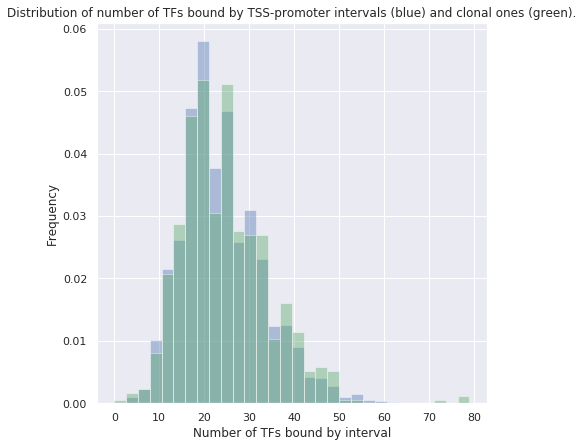

In [164]:
sns.distplot(TFBS_df.sum(axis=1), kde=False, norm_hist=True, bins=30)

sns.distplot(sigpeak_TFs.sum(axis=1), color='g', kde=False, norm_hist=True, bins=30)

plt.xlabel('Number of TFs bound by interval')
plt.ylabel('Frequency')
plt.title('Distribution of number of TFs bound by TSS-promoter intervals (blue) and clonal ones (green).')
plt.show()

The histograms above show a similar distribution.  I don't see a big difference between the number of TFs bound by clonal intervals, and the general population of TSS-promoter intervals.

We give each TF an "activity score" based on how many clonally significant peak intervals it binds to, relative to the total number of peak intervals it binds to.

In [159]:
act_score = sigpeak_TFs.sum(axis=0) / TFBS_df.sum(axis=0)
act_score.head()

NFIL3    0.049261
FOXF2    0.055118
FOXD1    0.059740
IRF2     0.052809
MZF1     0.051267
dtype: float64

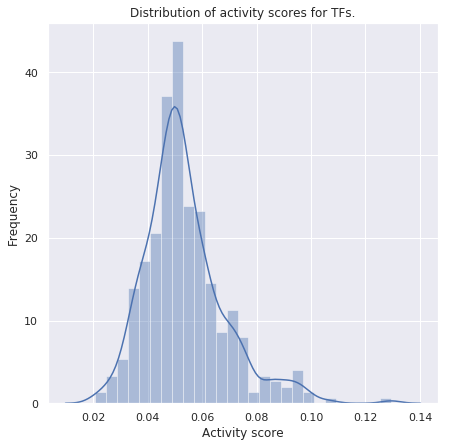

In [165]:
sns.distplot(act_score)
plt.xlabel('Activity score')
plt.ylabel('Frequency')
plt.title('Distribution of activity scores for TFs.')
plt.show()

The distribution of activity scores shows a bit of a bumpy tail at the high end.  We examine its statistical significance by comparison to 10000 random selections of intervals (rather than clonally significant ones).  It will take a minute to create the dataframe from 10000 random selections.

In [162]:
rand_scores = pd.DataFrame(index = TFBS_df.columns)
denominator = TFBS_df.sum(axis=0)
for j in range(10000):
    colname = 'Selection_'+str(j)
    selection = np.random.choice(TFBS_df.index, size=len(sig_TSSs), replace=False)
    sel_TFBS = TFBS_df.loc[selection]
    rand_scores[colname] = sel_TFBS.sum(axis=0) / denominator
rand_scores.head()

,Selection_0,Selection_1,Selection_2,Selection_3,Selection_4,Selection_5,Selection_6,Selection_7,Selection_8,Selection_9,...,Selection_9990,Selection_9991,Selection_9992,Selection_9993,Selection_9994,Selection_9995,Selection_9996,Selection_9997,Selection_9998,Selection_9999
NFIL3,0.044335,0.024631,0.044335,0.039409,0.039409,0.059113,0.019704,0.034483,0.049261,0.044335,...,0.034483,0.044335,0.044335,0.049261,0.054187,0.024631,0.044335,0.034483,0.054187,0.054187
FOXF2,0.034121,0.057743,0.065617,0.036745,0.060367,0.039370,0.049869,0.031496,0.057743,0.049869,...,0.036745,0.052493,0.055118,0.049869,0.052493,0.062992,0.044619,0.036745,0.052493,0.036745
FOXD1,0.033766,0.041558,0.051948,0.054545,0.038961,0.062338,0.051948,0.044156,0.049351,0.046753,...,0.036364,0.051948,0.041558,0.057143,0.046753,0.054545,0.049351,0.064935,0.054545,0.057143
IRF2,0.060674,0.058427,0.042697,0.047191,0.053933,0.049438,0.057303,0.059551,0.048315,0.047191,...,0.050562,0.050562,0.050562,0.046067,0.049438,0.043820,0.051685,0.051685,0.043820,0.048315
MZF1,0.048600,0.047414,0.049192,0.046822,0.049637,0.046822,0.050230,0.049341,0.047118,0.048452,...,0.050971,0.048007,0.048007,0.052008,0.048748,0.047711,0.048155,0.049489,0.050526,0.048303


We can ask whether the "activity scores" of transcription factors, computed from our clonal intervals, resembles the distribution of activity scores from a random selection of intervals.  

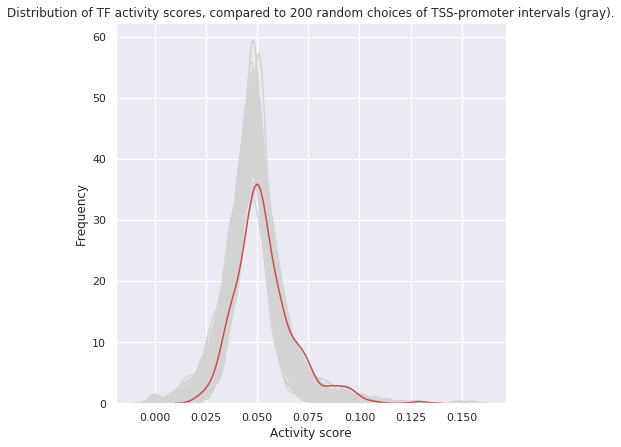

In [166]:
for j in range(200):
    sns.distplot(rand_scores['Selection_'+str(j)], color='lightgray', hist=False)
sns.distplot(act_score, color='r', hist=False)

plt.xlabel('Activity score')
plt.ylabel('Frequency')
plt.title('Distribution of TF activity scores, compared to 200 random choices of TSS-promoter intervals (gray).')
plt.show()

The "actual" distribution (in red) of activity scores shows a definite rightward shift, compared to the distributions arising from random choices of intervals (gray).

Now we look at which TFs seem significant, relative to the 10000 chance experiments.  We make cutoffs based on the 95th, 99th, and 99.9th percentiles in the 10000 chance experiments.

In [223]:
sig_cutoffs = pd.Series(np.percentile(rand_scores, 95, axis=1), index = rand_scores.index)
verysig_cutoffs = pd.Series(np.percentile(rand_scores, 99, axis=1), index = rand_scores.index)
wow_cutoffs = pd.Series(np.percentile(rand_scores, 99.9, axis=1), index = rand_scores.index)
sig_cutoffs.head()

NFIL3    0.073892
FOXF2    0.065617
FOXD1    0.064935
IRF2     0.059551
MZF1     0.050971
dtype: float64

The following TFs have activity scores which exceed 99.9% of the activity scores produced by the random experiments.

In [224]:
act_score[act_score > wow_cutoffs]

FOS      0.075610
FOSL1    0.076423
TBX2     0.083732
TEAD1    0.088000
dtype: float64

We store this information about TFs in a dataframe, and export it for sharing.

In [225]:
act_df = pd.DataFrame(act_score, columns = ['Activity Score'])
act_df['Z-score'] = (act_df['Activity Score'] - rand_scores.mean(axis=1)) / rand_scores.std(axis=1)
act_df['Binding intervals'] = TFBS_df.sum(axis=0)
act_df['Clonal intervals'] = sigpeak_TFs.sum(axis=0)
for TF in act_df.index:
    if act_score[TF] > wow_cutoffs[TF]:
        act_df.at[TF,'p-value'] = 'p < 0.001'
    elif act_score[TF] > verysig_cutoffs[TF]:
        act_df.at[TF,'p-value'] = 'p < 0.01'
    elif act_score[TF] > sig_cutoffs[TF]:
        act_df.at[TF,'p-value'] = 'p < 0.05'
    else:
        act_df.at[TF,'p-value'] = ''

act_df.sort_values(by = 'Z-score', ascending=False)

,Activity Score,Z-score,Binding intervals,Clonal intervals,p-value
FOS,0.075610,3.801444,820,62,p < 0.001
TEAD1,0.088000,3.650192,375,33,p < 0.001
PDX1,0.129412,3.559608,85,11,p < 0.01
HOXB3,0.100000,3.544123,210,21,p < 0.01
TBX2,0.083732,3.448403,418,35,p < 0.001
FOSL1,0.076423,3.357954,615,47,p < 0.001
FOSL2,0.077465,3.324697,568,44,p < 0.01
HOXB2,0.098446,3.283034,193,19,p < 0.01
TBX15,0.070761,3.044614,749,53,p < 0.01
TBX1,0.077083,3.041995,480,37,p < 0.01


In [226]:
TF_active = act_df[ act_df['p-value'] != ''].index
print('The following TFs bind to the clonal intervals, at a p < 0.05 level: {}.'.format(', '.join(TF_active)))

The following TFs bind to the clonal intervals, at a p < 0.05 level: MZF1, FOS, FOSL1, FOSL2, FOXP1, JUN, JUNB, NFYB, EMX1, POU6F1, EN1, MEOX1, MSC, NEUROD2, NEUROG2, PAX7, TBX2, TBX20, TBX21, TEAD1, ZBTB18, PDX1, VAX1, VAX2, ZNF410, ZNF740, PAX3, PKNOX1, POU1F1, POU3F2, POU3F4, POU5F1B, TGIF2, EOMES, MGA, TBX15, TBX1, TBX4, TBX5, TEAD4, TFAP2B, BHLHE23, BHLHE22, OLIG1, EMX2, EVX2, HOXB2, HOXB3, ISL2, TAL1, BATF, GATA1.


A more robust statistic will be needed to find an appropriate set of TFs and evaluate statistical significance (or lack thereof).

In [221]:
act_df.sort_values(by = 'Z-score', ascending=False).to_csv('ATAC_significant_TFs.csv')

In [222]:
ATAC_sig = sig_peaks.sort_values(ascending=False)
ATAC_sig.to_csv('ATAC_significant_peaks.csv')